<a href="https://colab.research.google.com/github/ritwikraha/GenerativeFill-with-Keras-and-Diffusers/blob/main/grounding_dino_sam-inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq keras-cv
!pip install -Uq keras
!pip install -qq diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 982.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 28.9 MB/s eta 0:00:00


In [2]:
!pip install -U git+https://github.com/IDEA-Research/GroundingDINO.git

  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-_w8mckyy
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-_w8mckyy
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 2b62f419c292ca9c518daae55512fabc3fead4a4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 11.3 MB/s eta 0:00:00
  Created wheel for groundingdino: filename=groundingdino-0.1.0-cp310-cp310-linux_x86_64.whl size=2882819 sha256=8d473d428ed5d868bbc3285e5e34324820a70c5419115303705e074c58691563
  Stored in directory: /tmp/pip-ephem-wheel-cache-fkp0y07o/wheels/6b/06/d7/b57f601a4df56af41d262a5b1b496359b13c323bf5ef0434b2
Successfully built groundingdino


In [3]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py

In [12]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import torch

import timeit
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import ops
import keras_cv

from PIL import Image
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
from groundingdino.util.inference import Model as GroundingDINO

In [5]:
CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDINO(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def inference_resizing(image, pad=True):
    # Compute Preprocess Shape
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # Resize the image
    image = ops.image.resize(image[None, ...], preprocess_shape)[0]

    # Pad the shorter side
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasCV now rescales the images and normalizes them.
        # Just unnormalize such that when KerasCV normalizes them
        # again, the padded values map to 0.
        image = image * pixel_std + pixel_mean
    return image

In [7]:
model = keras_cv.models.SegmentAnythingModel.from_preset("sam_huge_sa1b")

100%|██████████| 3.38k/3.38k [00:00<00:00, 7.61MB/s]
100%|██████████| 2.39G/2.39G [00:36<00:00, 70.8MB/s]


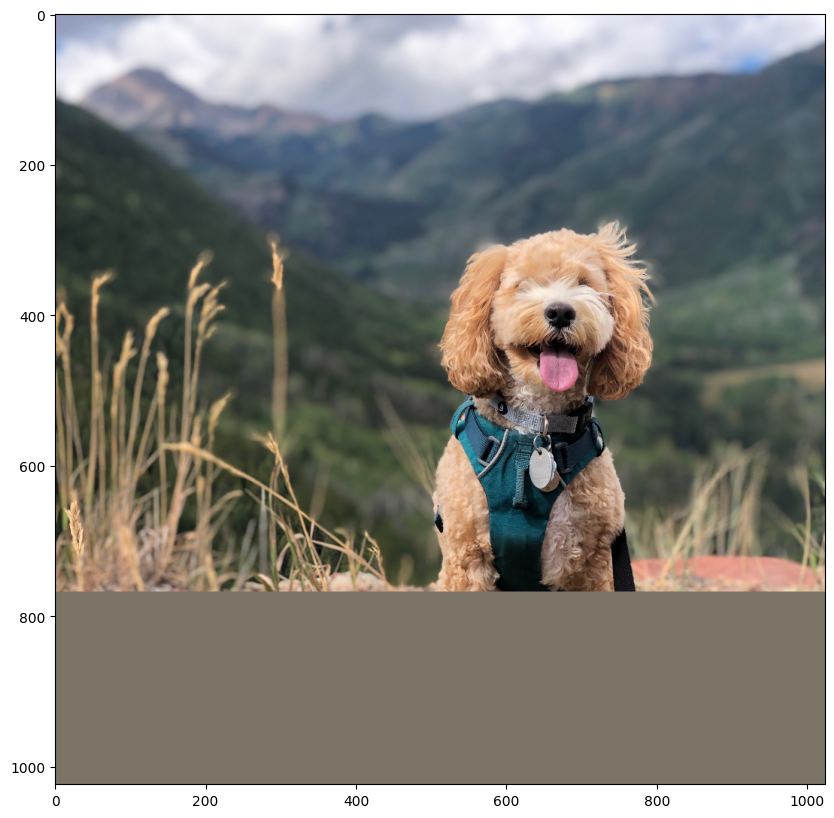

In [38]:
filepath = keras.utils.get_file(
    origin="https://storage.googleapis.com/keras-cv/test-images/mountain-dog.jpeg"
)
image = np.array(keras.utils.load_img(filepath))
image = ops.convert_to_numpy(inference_resizing(image))

plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)
plt.axis("on")
plt.show()

In [10]:
# Let's predict the bounding box for the harness of the dog
boxes = grounding_dino.predict_with_caption(image.astype(np.uint8), "harness")
boxes = np.array(boxes[0].xyxy)

outputs = model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2),
    },
    batch_size=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 138s 138s/step


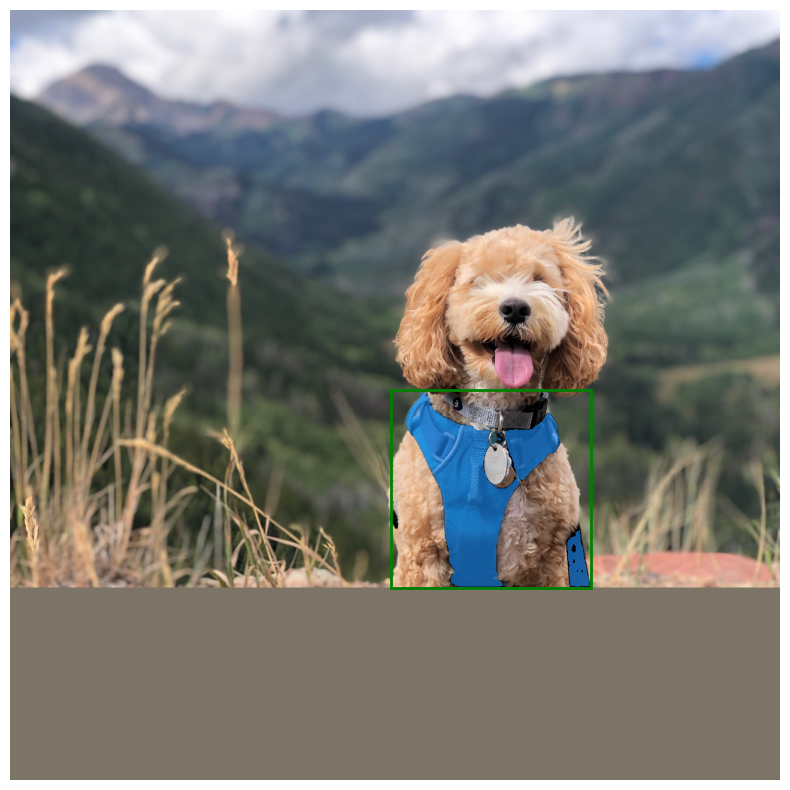

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)

for mask in outputs["masks"]:
    mask = inference_resizing(mask[0][..., None], pad=False)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    show_mask(mask, plt.gca())
    show_box(boxes, plt.gca())

plt.axis("off")
plt.show()

In [15]:
image.dtype

dtype('float32')

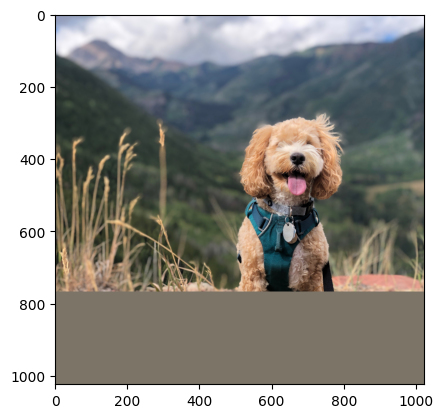

In [43]:
plt.imshow(image/255.0)

In [60]:
# load base and mask image
init_image = Image.fromarray(image.astype(np.uint8))
mask_image = Image.fromarray(mask)

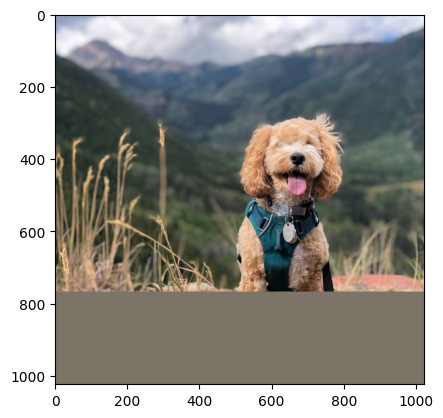

In [61]:
plt.imshow(init_image)

In [18]:

pipeline = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16, variant="fp16"
)
pipeline.enable_model_cpu_offload()



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [62]:
prompt = "a backpack made of chocolates, highly detailed, 8k"
output = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, strength=0.6).images[0]


  0%|          | 0/30 [00:00<?, ?it/s]

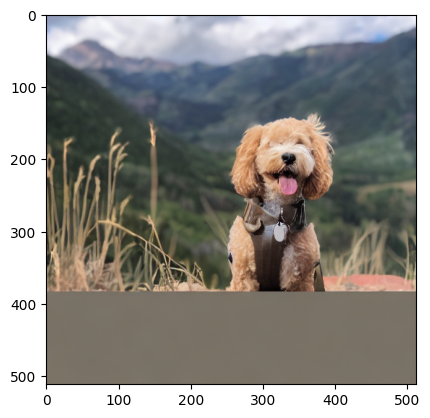

In [63]:
plt.imshow(output)